In [1]:
from sklearn.model_selection import train_test_split
from skimage.filters import threshold_multiotsu
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn import metrics
from pathlib import Path
from sklearn import svm
from osgeo import gdal
import seaborn as sn
import pandas as pd
import numpy as np
# import rasterio
import pickle
import cv2

In [2]:
def normalize(raster, n=3500):
    """Normaliza la imagen
    primero todos los valores a n los iguala a n
    déspues normaliza la imagen resultante entre valores entr 0 y 255"""
    raster[raster>n]=n
    min_raster, max_raster, new_max, new_min = raster.min(), raster.max(), 255, 0
    return ((raster-min_raster)*((new_max-new_min)/(max_raster-min_raster))+new_min).astype(int)

In [3]:
path_sentinel = Path(r'C:\Users\nicom\Desktop\MAESTRIA\Maestria_semestre_2\Remote_sensing\remote-sensing\SENTINEL\L1C_T18SUH_A020529_20210209T155442\S2B_MSIL1C_20210209T155309_N0209_R054_T18SUH_20210209T193948.SAFE\GRANULE\L1C_T18SUH_A020529_20210209T155442\IMG_DATA')
# Se guarda la ruta de las imágenes con extensión jp2
sentinel_images = list(path_sentinel.glob('**/*.jp2'))
layers = []
for sentinel_image in sentinel_images:
    # Carga de datos con GDAL
    image = gdal.Open(str(sentinel_image))
    bands, xSize, ySize = image.RasterCount, image.RasterXSize, image.RasterYSize
    name = sentinel_image.stem.split('_')[-1]
    if bands == 1 and xSize == 10980:
        print(f"Image {name} loaded: # Ráster {bands}, {xSize}, {ySize}")
        layers.append(image.GetRasterBand(1).ReadAsArray()[150:400,70:300])
layers.reverse()

Image B02 loaded: # Ráster 1, 10980, 10980
Image B03 loaded: # Ráster 1, 10980, 10980
Image B04 loaded: # Ráster 1, 10980, 10980
Image B08 loaded: # Ráster 1, 10980, 10980


In [4]:
cube = np.dstack(layers)

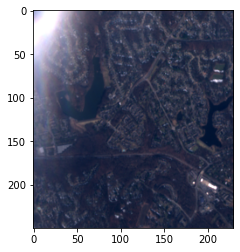

In [5]:
plt.imshow(normalize(cube[:,:,1:]))

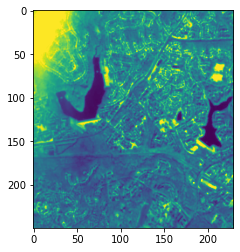

In [6]:
plt.imshow(normalize(cube[:,:,0]))

In [7]:
thresholds = threshold_multiotsu(cube[:,:,0]) # Se usó la capa de infrarojo
thresholds

array([1648, 2501])

In [8]:
# Using the threshold values, we generate the three regions.
classification_map = np.digitize(cube[:,:,0], bins=thresholds)

(-0.5, 229.5, 249.5, -0.5)

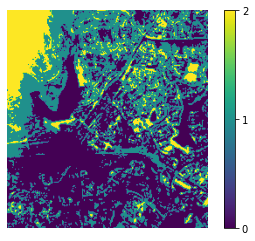

In [9]:
bars = plt.imshow(classification_map, cmap='viridis')
color_bar = plt.colorbar(bars, ticks=range(3))
plt.axis('off')

In [10]:
w, h, c = cube.shape
x_sentinel2d = cube.reshape((w * h, c))
y_sentinel2d = classification_map.reshape((w * h, 1))

In [11]:
sentinel_train, sentinel_test, sentinel_y_train, sentinel_y_test = train_test_split(x_sentinel2d,
                                                                                    y_sentinel2d,
                                                                                    test_size=0.8, 
                                                                                    random_state=42)

In [12]:
svm_sentinel =  svm.SVC(C=100, kernel='rbf', cache_size=10*1024)

In [13]:
%%time
svm_sentinel.fit(sentinel_train, sentinel_y_train.ravel())

Wall time: 1.63 s


SVC(C=100, cache_size=10240)

In [14]:
%%time
y_pred = svm_sentinel.predict(sentinel_test)

Wall time: 1.19 s


In [15]:
# Model Accuracy: how often is the classifier correct?
print("Precisión SENTINEL :",metrics.accuracy_score(y_pred, sentinel_y_test))

Precisión Indian Pines : 0.9979347826086956


In [16]:
out_sentinel = confusion_matrix(sentinel_y_test, y_pred)
out_sentinel = np.round(out_sentinel/out_sentinel.max(), 3)

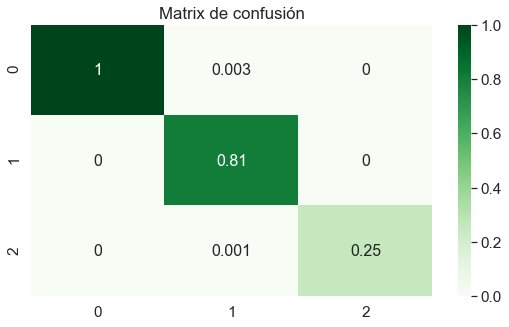

In [17]:
df_cm = pd.DataFrame(out_sentinel, range(3), range(3))
plt.figure(figsize=(9, 5))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, cmap="Greens", annot=True, annot_kws={"size": 16}) # font size
plt.title("Matrix de confusión")
plt.show()

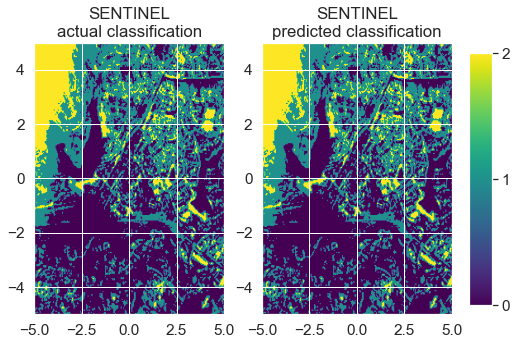

In [18]:
recompose_image = svm_sentinel.predict(x_sentinel2d).reshape(classification_map.shape) # Wall time: 15.6 s

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
im1 = axes[0].imshow(classification_map, extent=(-5,5,-5,5), aspect='auto', cmap='viridis')
tx1 = axes[0].set_title("SENTINEL\nactual classification")
im2 = axes[1].imshow(recompose_image, extent=(-5,5,-5,5), aspect='auto', cmap='viridis')
tx2 = axes[1].set_title("SENTINEL\npredicted classification")
# add space for colour bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
bar = fig.colorbar(im2, cax=cbar_ax, ticks=range(10))